In [1]:
!gdown --id 1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V


/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V
To: /content/NonLinear_data.npy
100% 5.57k/5.57k [00:00<00:00, 8.63MB/s]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)


In [4]:
data_path = './NonLinear_data.npy'  # Đường dẫn đến file
data = np.load(data_path, allow_pickle=True).item()
X, y = data['X'], data['labels']

print(X.shape, y.shape)  # Kiểm tra kích thước dữ liệu
# Output: (300, 2) (300,)


(300, 2) (300,)


In [5]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=val_size, random_state=random_state, shuffle=is_shuffle)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=test_size, random_state=random_state, shuffle=is_shuffle)


In [6]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

# Chuyển sang tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)


In [7]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [8]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        out = self.output(x)
        return out

input_dims = X_train.shape[1]
output_dims = torch.unique(y_train).shape[0]
hidden_dims = 128

model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(device)


In [9]:
lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)


In [10]:
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy


In [11]:
epochs = 100
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    train_loss, val_loss = 0.0, 0.0
    train_target, train_predict = [], []
    val_target, val_predict = [], []

    # Training phase
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples, y_samples = X_samples.to(device), y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_accs.append(compute_accuracy(train_predict, train_target))

    # Validation phase
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples, y_samples = X_samples.to(device), y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()
            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_accs.append(compute_accuracy(val_predict, val_target))

    print(f'EPOCH {epoch+1}: Training Loss: {train_loss:.3f}, Validation Loss: {val_loss:.3f}')


EPOCH 1: Training Loss: 0.939, Validation Loss: 0.864
EPOCH 2: Training Loss: 0.750, Validation Loss: 0.815
EPOCH 3: Training Loss: 0.715, Validation Loss: 0.799
EPOCH 4: Training Loss: 0.689, Validation Loss: 0.791
EPOCH 5: Training Loss: 0.670, Validation Loss: 0.780
EPOCH 6: Training Loss: 0.654, Validation Loss: 0.747
EPOCH 7: Training Loss: 0.646, Validation Loss: 0.724
EPOCH 8: Training Loss: 0.616, Validation Loss: 0.704
EPOCH 9: Training Loss: 0.616, Validation Loss: 0.694
EPOCH 10: Training Loss: 0.610, Validation Loss: 0.666
EPOCH 11: Training Loss: 0.577, Validation Loss: 0.666
EPOCH 12: Training Loss: 0.596, Validation Loss: 0.642
EPOCH 13: Training Loss: 0.556, Validation Loss: 0.625
EPOCH 14: Training Loss: 0.537, Validation Loss: 0.608
EPOCH 15: Training Loss: 0.521, Validation Loss: 0.604
EPOCH 16: Training Loss: 0.530, Validation Loss: 0.587
EPOCH 17: Training Loss: 0.511, Validation Loss: 0.566
EPOCH 18: Training Loss: 0.498, Validation Loss: 0.569
EPOCH 19: Training 

In [12]:
test_target, test_predict = [], []

model.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples, y_samples = X_samples.to(device), y_samples.to(device)
        outputs = model(X_samples)
        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)
test_acc = compute_accuracy(test_predict, test_target)

print('Evaluation on test set:')
print(f'Accuracy: {test_acc:.3f}')


Evaluation on test set:
Accuracy: 0.933


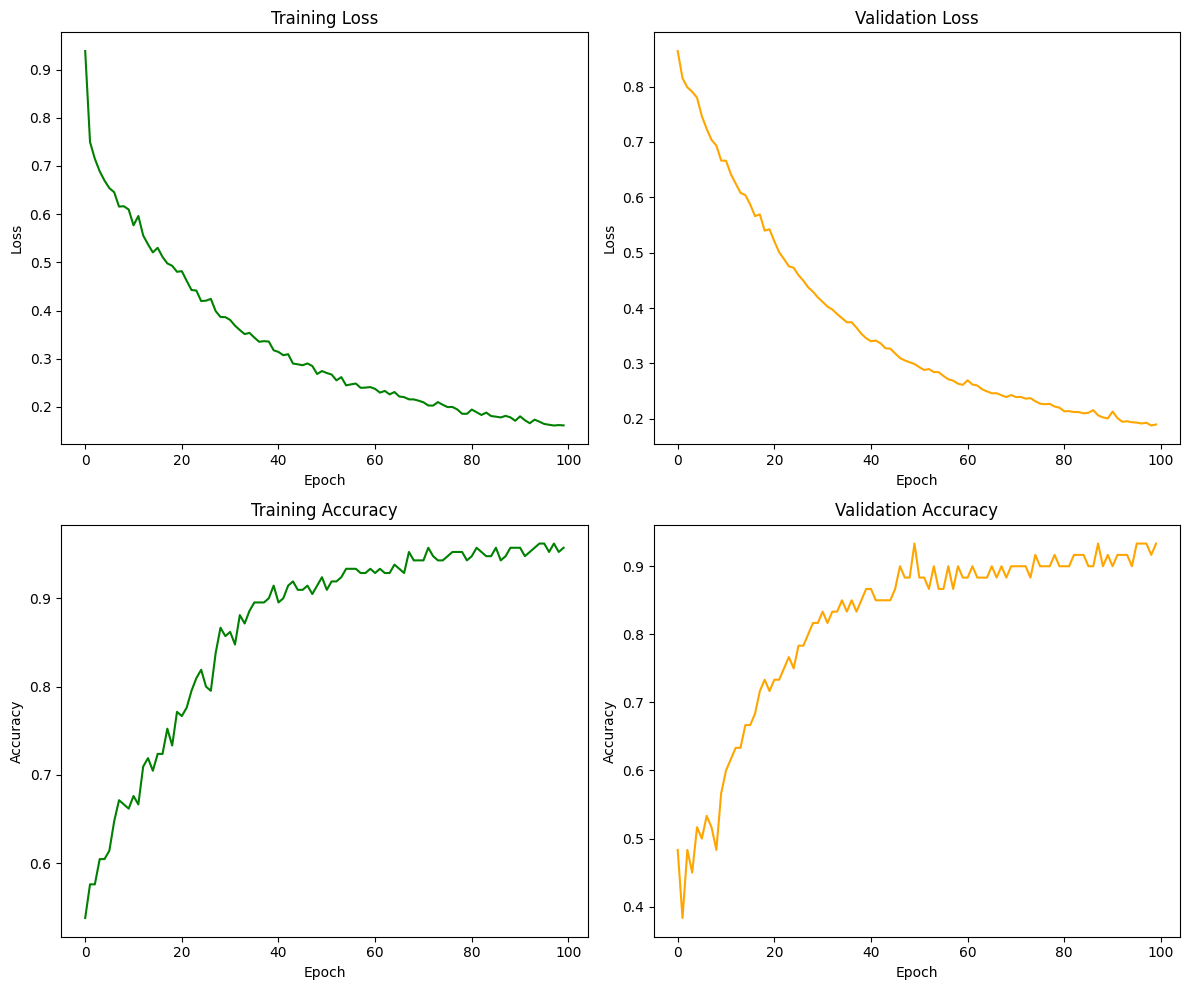

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Training Loss
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

# Validation Loss
ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

# Training Accuracy
ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

# Validation Accuracy
ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.tight_layout()
plt.show()
